# Experiment Result

# CONTENTS

1. [P-Values Cloud](#P-Values-Cloud)
2. [T-Statistic for each category (baseline model)](#T-Statistic-For-Each-Category-Baseline)
3. [Test Statistics](#Test-Statistics)
4. [Hypothesis Test Results SNLI](#Hypothesis-Test-Results-SNLI)
5. [Hypothesis Test Results MNLI](#Hypothesis-Test-Results-MNLI)
6. [Accuracy-Deep Models SNLI](#Accuracy-Deep-Models-SNLI)
7. [Accuracy Deep Models MNLI](#Accuracy-Deep-Models-MNLI)
8. [Best Rho Table](#Best-Rho-Table)
9. [Model-Sharpe-Ratio](#Model-Sharpe-Ratio)
10. [T-Statistic for each category Deep Model SNLI](#T-Statistic-For-Each-Category-Deep-Model-SNLI)
11. [T-Statistic for each category Deep Model MNLI](#T-Statistic-For-Each-Category-Deep-Model-MNLI)
12. [Accuracy for the entailment category Deep-Model SNLI](#Accuracy-For-The-Entailment-Category-Deep-Model-SNLI)
13. [Accuracy for the entailment category Deep-Model MNLI](#Accuracy-For-The-Entailment-Category-Deep-Model-MNLI)




In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML, Markdown 
from lr.analysis.util import get_ts_from_results_folder 
from lr.stats.h_testing import get_paired_t_statistic
from matplotlib.ticker import FuncFormatter
from glob import glob

### Functions

In [2]:
def f_percentage(x, pos):
    """
    Adds percentage sign to plot ticks.
    """

    return '{:.1%}'.format(x)

y_axis_formatter = FuncFormatter(f_percentage)

def get_ts_from_path(base_path, nli_map):
    rhos = []
    neutral_t = []
    contradiction_t = []
    entailment_t = []
    paths =  glob(base_path)

    for path in paths:
        df = pd.read_csv(path)
        df.label = df.label.map(lambda x: nli_map[x])
        df_n = df.query("label=='neutral'")
        df_c = df.query("label=='contradiction'")
        df_e = df.query("label=='entailment'")
        t_n, _,_,_ = get_paired_t_statistic(df_n)
        t_c, _,_,_ = get_paired_t_statistic(df_c)
        t_e, _,_,_ = get_paired_t_statistic(df_e)
        rho = path.split("/")[-1].split("_")[1].replace("p",".")
        rho = float(rho)
        neutral_t.append(t_n)
        contradiction_t.append(t_c)
        entailment_t.append(t_e)
        rhos.append(rho)

    neutral_t = pd.Series(neutral_t,index=rhos).sort_index()
    contradiction_t = pd.Series(contradiction_t,index=rhos).sort_index()
    entailment_t = pd.Series(entailment_t,index=rhos).sort_index()
    neutral_t.name = "neutral"
    contradiction_t.name = "contradiction"
    entailment_t.name = "entailment"
    return neutral_t, contradiction_t, entailment_t



def get_acc_from_ent(base_path, nli_map):
    rhos = []
    entailment_acc = []
    entailment_acc_t = []
    
    paths =  glob(base_path)

    for path in paths:
        df = pd.read_csv(path)
        df.label = df.label.map(lambda x: nli_map[x])
        df_e = df.query("label=='entailment'")
        rho = path.split("/")[-1].split("_")[1].replace("p",".")
        rho = float(rho)

        entailment_acc.append(df_e.A.mean())
        entailment_acc_t.append(df_e.B.mean())        
        rhos.append(rho)

    entailment_acc = pd.Series(entailment_acc,index=rhos).sort_index()
    entailment_acc_t = pd.Series(entailment_acc_t,index=rhos).sort_index()
    entailment_acc.name = "original accuracy"
    entailment_acc_t.name = "transformed accuracy"
    return entailment_acc, entailment_acc_t


def get_cloud_p_values(p_values_df, alpha=0.05, test_repetitions=5):    
    rhos = p_values_df.index
    mean_p_values = p_values_df.mean(1).values
    error_p_values = p_values_df.std(1).values
    min_p_values  = p_values_df.min(1).values


    alpha_adj = alpha / test_repetitions

    rejected_ids = []
    remain_ids = []

    for i,p in enumerate(min_p_values):
        if p < alpha_adj:
            rejected_ids.append(i)
        else:
            remain_ids.append(i)

    rhos_rejected = rhos[rejected_ids]
    rhos_remain = rhos[remain_ids]
    y_rejected = mean_p_values[rejected_ids]
    y_remain = mean_p_values[remain_ids]
    error_rejected = error_p_values[rejected_ids]
    error_remain = error_p_values[remain_ids]
    return rhos_rejected, rhos_remain, y_rejected, y_remain, error_rejected, error_remain

## P-Values Baseline

100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


# P-Values-Cloud

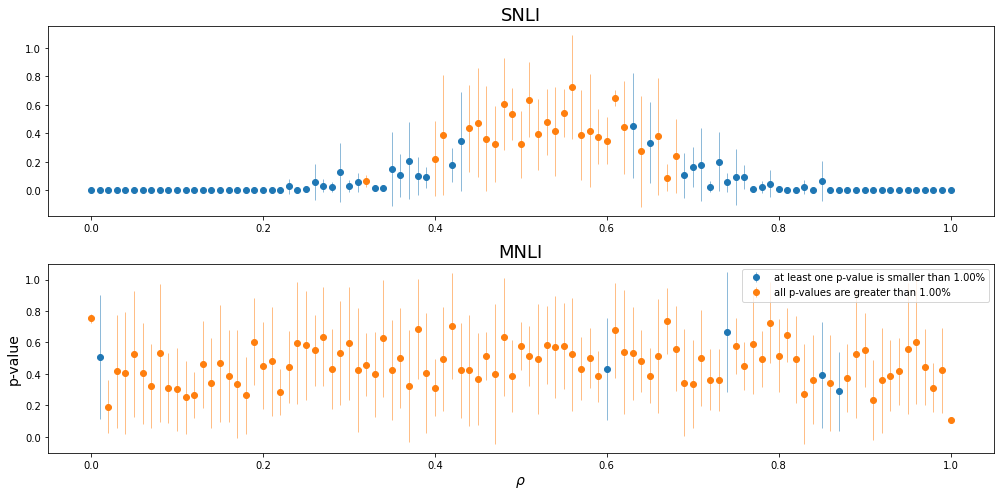

In [3]:
folder = "snli"

all_paired_t_p_values_snli = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    paired_t_p_value  = get_ts_from_results_folder(path="results/{}/xgb/syn_p_h/batch{}/".format(folder, i),
                                                    stat="paired_t_p_value")
    
    all_paired_t_p_values_snli.append(paired_t_p_value)
    
all_paired_t_p_values_snli = pd.concat(all_paired_t_p_values_snli, 1)
all_paired_t_p_values_snli.columns = batchs

folder = "mnli"

all_paired_t_p_values_mnli = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
        
    paired_t_p_value  = get_ts_from_results_folder(path="results/{}/xgb/syn_p_h/batch{}/".format(folder, i),
                                                    stat="paired_t_p_value")
    
    all_paired_t_p_values_mnli.append(paired_t_p_value)
    
all_paired_t_p_values_mnli = pd.concat(all_paired_t_p_values_mnli, 1)
all_paired_t_p_values_mnli.columns = batchs

rhos_rejected_snli, rhos_remain_snli, y_rejected_snli, y_remain_snli, error_rejected_snli, error_remain_snli = get_cloud_p_values(all_paired_t_p_values_snli)
rhos_rejected_mnli, rhos_remain_mnli, y_rejected_mnli, y_remain_mnli, error_rejected_mnli, error_remain_mnli = get_cloud_p_values(all_paired_t_p_values_mnli)

alpha = 0.05
alpha_adj = alpha / test_repetitions



fig, ax = plt.subplots(2,figsize=(14,7))
ax[0].errorbar(rhos_rejected_snli, y_rejected_snli, yerr=error_rejected_snli, fmt='o', linewidth=0.50, label="at least one p-value is smaller than {:.2%}".format(alpha_adj));
ax[0].errorbar(rhos_remain_snli, y_remain_snli, yerr=error_remain_snli, fmt='o', linewidth=0.50, label="all p-values are greater than {:.2%}".format(alpha_adj));
ax[1].errorbar(rhos_rejected_mnli, y_rejected_mnli, yerr=error_rejected_mnli, fmt='o', linewidth=0.50, label="at least one p-value is smaller than {:.2%}".format(alpha_adj));
ax[1].errorbar(rhos_remain_mnli, y_remain_mnli, yerr=error_remain_mnli, fmt='o', linewidth=0.50, label="all p-values are greater than {:.2%}".format(alpha_adj));
ax[1].legend(loc="best");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("p-value", fontsize=14);
ax[1].set_title("MNLI", fontsize=18);
ax[0].set_title("SNLI", fontsize=18);
fig.tight_layout()
fig.tight_layout()
fig.savefig('figs/paper/baseline_p_values_cloud.png', bbox_inches=None, pad_inches=0.5)

display(Markdown("# P-Values-Cloud"))

## Test Statistics per category (Baseline)

100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


# T-Statistic-For-Each-Category-Baseline

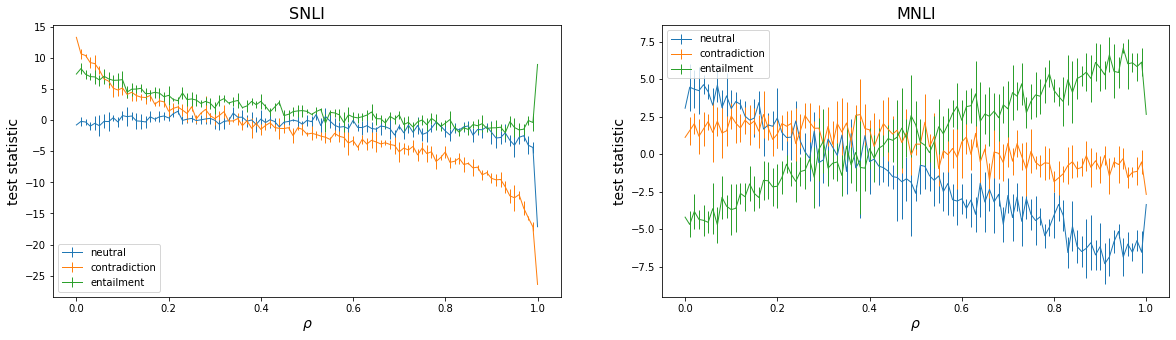

In [4]:
nli2ternary = {1: "entailment",
               -1: "contradiction",
               0: "neutral"}

folder = "snli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)
all_n_snli = []
all_c_snli = []
all_e_snli = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/xgb/syn_p_h/batch{}/*.csv".format(folder, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_snli.append(neutral_t)
    all_c_snli.append(contradiction_t)
    all_e_snli.append(entailment_t)
    
all_n_snli = pd.concat(all_n_snli, 1)
all_c_snli = pd.concat(all_c_snli, 1)
all_e_snli = pd.concat(all_e_snli, 1)

folder = "mnli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)
all_n_mnli = []
all_c_mnli = []
all_e_mnli = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/xgb/syn_p_h/batch{}/*.csv".format(folder, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_mnli.append(neutral_t)
    all_c_mnli.append(contradiction_t)
    all_e_mnli.append(entailment_t)
    
all_n_mnli = pd.concat(all_n_mnli, 1)
all_c_mnli = pd.concat(all_c_mnli, 1)
all_e_mnli = pd.concat(all_e_mnli, 1)

df_snli = pd.concat([all_n_snli.mean(1), all_c_snli.mean(1), all_e_snli.mean(1)], 1)
df_mnli = pd.concat([all_n_mnli.mean(1), all_c_mnli.mean(1), all_e_mnli.mean(1)], 1)
df_snli.columns = ["neutral", "contradiction", "entailment"]
df_mnli.columns = ["neutral", "contradiction", "entailment"]
corr_snli = df_snli.corr()
mask_snli = np.triu(np.ones_like(corr_snli, dtype=bool))
corr_mnli = df_mnli.corr()
mask_mnli = np.triu(np.ones_like(corr_mnli, dtype=bool))

fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].errorbar(all_n_snli.index, all_n_snli.mean(1), yerr=all_n_snli.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[0].errorbar(all_c_snli.index, all_c_snli.mean(1), yerr=all_c_snli.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[0].errorbar(all_e_snli.index, all_e_snli.mean(1), yerr=all_e_snli.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[0].set_xlabel(r"$\rho$", fontsize=14);
ax[0].set_ylabel("test statistic", fontsize=14);
ax[0].legend(loc="best");

ax[1].errorbar(all_n_mnli.index, all_n_mnli.mean(1), yerr=all_n_mnli.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[1].errorbar(all_c_mnli.index, all_c_mnli.mean(1), yerr=all_c_mnli.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[1].errorbar(all_e_mnli.index, all_e_mnli.mean(1), yerr=all_e_mnli.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("test statistic", fontsize=14);
ax[1].legend(loc="best");

# Adjust vertical_spacing = 0.5 * axes_height
plt.subplots_adjust(hspace=0.3, wspace=0.2)

ax[0].set_title("SNLI", fontsize=16);
ax[1].set_title("MNLI", fontsize=16);
fig.savefig('figs/paper/baseline_t_stas_cat.png', bbox_inches=None, pad_inches=0.5)
display(Markdown("# T-Statistic-For-Each-Category-Baseline"))

## Test Statistic for Different Levels

100%|██████████| 5/5 [00:00<00:00, 16.69it/s]


# Test-Statistics

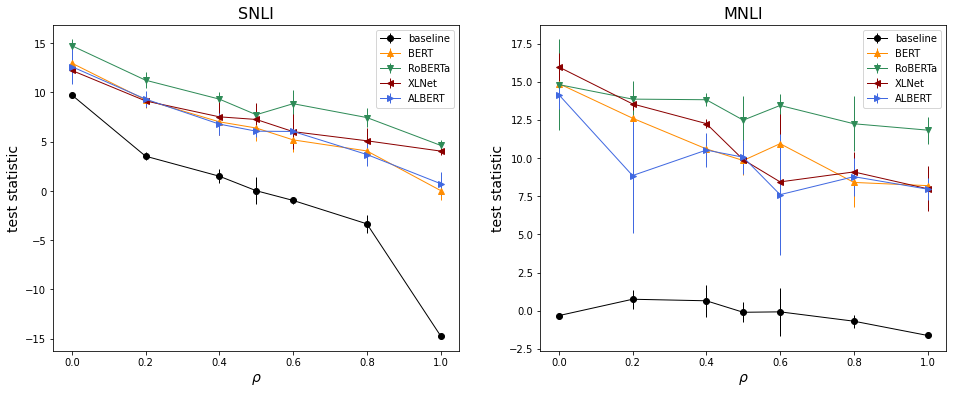

In [5]:
# SNLI

model = "xgb"
folder="snli"

paired_t_p_values_snli_baseline = []
observable_paired_t_stats_snli_baseline = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_baseline.append(p)
    observable_paired_t_stats_snli_baseline.append(t)
    
paired_t_p_values_snli_baseline = pd.concat(paired_t_p_values_snli_baseline, 1)
paired_t_p_values_snli_baseline.columns = batchs
paired_t_p_values_snli_baseline = paired_t_p_values_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

observable_paired_t_stats_snli_baseline = pd.concat(observable_paired_t_stats_snli_baseline, 1)
observable_paired_t_stats_snli_baseline.columns = batchs
observable_paired_t_stats_snli_baseline = observable_paired_t_stats_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]


model = "bert_base"

paired_t_p_values_snli_bert = []
observable_paired_t_stats_snli_bert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_bert.append(p)
    observable_paired_t_stats_snli_bert.append(t)
    
paired_t_p_values_snli_bert = pd.concat(paired_t_p_values_snli_bert, 1)
paired_t_p_values_snli_bert.columns = batchs

observable_paired_t_stats_snli_bert = pd.concat(observable_paired_t_stats_snli_bert, 1)
observable_paired_t_stats_snli_bert.columns = batchs


model = "roberta_base"

paired_t_p_values_snli_roberta = []
observable_paired_t_stats_snli_roberta = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_roberta.append(p)
    observable_paired_t_stats_snli_roberta.append(t)
    
paired_t_p_values_snli_roberta = pd.concat(paired_t_p_values_snli_roberta, 1)
paired_t_p_values_snli_roberta.columns = batchs

observable_paired_t_stats_snli_roberta = pd.concat(observable_paired_t_stats_snli_roberta, 1)
observable_paired_t_stats_snli_roberta.columns = batchs


model = "xlnet_base"

paired_t_p_values_snli_xlnet = []
observable_paired_t_stats_snli_xlnet = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_xlnet.append(p)
    observable_paired_t_stats_snli_xlnet.append(t)
    
paired_t_p_values_snli_xlnet = pd.concat(paired_t_p_values_snli_xlnet, 1)
paired_t_p_values_snli_xlnet.columns = batchs

observable_paired_t_stats_snli_xlnet = pd.concat(observable_paired_t_stats_snli_xlnet, 1)
observable_paired_t_stats_snli_xlnet.columns = batchs

model = "albert_base"

paired_t_p_values_snli_albert = []
observable_paired_t_stats_snli_albert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_albert.append(p)
    observable_paired_t_stats_snli_albert.append(t)
    
paired_t_p_values_snli_albert = pd.concat(paired_t_p_values_snli_albert, 1)
paired_t_p_values_snli_albert.columns = batchs

observable_paired_t_stats_snli_albert = pd.concat(observable_paired_t_stats_snli_albert, 1)
observable_paired_t_stats_snli_albert.columns = batchs


# MNLI
model = "xgb"
folder="mnli"

paired_t_p_values_mnli_baseline = []
observable_paired_t_stats_mnli_baseline = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_baseline.append(p)
    observable_paired_t_stats_mnli_baseline.append(t)
    
paired_t_p_values_mnli_baseline = pd.concat(paired_t_p_values_mnli_baseline, 1)
paired_t_p_values_mnli_baseline.columns = batchs
paired_t_p_values_mnli_baseline = paired_t_p_values_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

observable_paired_t_stats_mnli_baseline = pd.concat(observable_paired_t_stats_mnli_baseline, 1)
observable_paired_t_stats_mnli_baseline.columns = batchs
observable_paired_t_stats_mnli_baseline = observable_paired_t_stats_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]


model = "bert_base"

paired_t_p_values_mnli_bert = []
observable_paired_t_stats_mnli_bert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_bert.append(p)
    observable_paired_t_stats_mnli_bert.append(t)
    
paired_t_p_values_mnli_bert = pd.concat(paired_t_p_values_mnli_bert, 1)
paired_t_p_values_mnli_bert.columns = batchs

observable_paired_t_stats_mnli_bert = pd.concat(observable_paired_t_stats_mnli_bert, 1)
observable_paired_t_stats_mnli_bert.columns = batchs


model = "roberta_base"

paired_t_p_values_mnli_roberta = []
observable_paired_t_stats_mnli_roberta = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_roberta.append(p)
    observable_paired_t_stats_mnli_roberta.append(t)
    
paired_t_p_values_mnli_roberta = pd.concat(paired_t_p_values_mnli_roberta, 1)
paired_t_p_values_mnli_roberta.columns = batchs

observable_paired_t_stats_mnli_roberta = pd.concat(observable_paired_t_stats_mnli_roberta, 1)
observable_paired_t_stats_mnli_roberta.columns = batchs


model = "xlnet_base"

paired_t_p_values_mnli_xlnet = []
observable_paired_t_stats_mnli_xlnet = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_xlnet.append(p)
    observable_paired_t_stats_mnli_xlnet.append(t)
    
paired_t_p_values_mnli_xlnet = pd.concat(paired_t_p_values_mnli_xlnet, 1)
paired_t_p_values_mnli_xlnet.columns = batchs

observable_paired_t_stats_mnli_xlnet = pd.concat(observable_paired_t_stats_mnli_xlnet, 1)
observable_paired_t_stats_mnli_xlnet.columns = batchs

model = "albert_base"

paired_t_p_values_mnli_albert = []
observable_paired_t_stats_mnli_albert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_albert.append(p)
    observable_paired_t_stats_mnli_albert.append(t)
    
paired_t_p_values_mnli_albert = pd.concat(paired_t_p_values_mnli_albert, 1)
paired_t_p_values_mnli_albert.columns = batchs

observable_paired_t_stats_mnli_albert = pd.concat(observable_paired_t_stats_mnli_albert, 1)
observable_paired_t_stats_mnli_albert.columns = batchs

# PLOT

fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].errorbar(observable_paired_t_stats_snli_baseline.index,
            observable_paired_t_stats_snli_baseline.mean(1),
            yerr=observable_paired_t_stats_snli_baseline.std(1),
            fmt='-', linewidth=1.00, label="baseline",  marker="o", color="k");

ax[0].errorbar(observable_paired_t_stats_snli_bert.index,
            observable_paired_t_stats_snli_bert.mean(1),
            yerr=observable_paired_t_stats_snli_bert.std(1),
            fmt='-', linewidth=1.00, label="BERT",  marker="^", color="darkorange");

ax[0].errorbar(observable_paired_t_stats_snli_roberta.index,
            observable_paired_t_stats_snli_roberta.mean(1),
            yerr=observable_paired_t_stats_snli_roberta.std(1),
            fmt='-', linewidth=1.00, label="RoBERTa",  marker="v", color="seagreen");


ax[0].errorbar(observable_paired_t_stats_snli_xlnet.index,
            observable_paired_t_stats_snli_xlnet.mean(1),
            yerr=observable_paired_t_stats_snli_xlnet.std(1),
            fmt='-', linewidth=1.00, label="XLNet",  marker="<", color="darkred");


ax[0].errorbar(observable_paired_t_stats_snli_albert.index,
            observable_paired_t_stats_snli_albert.mean(1),
            yerr=observable_paired_t_stats_snli_albert.std(1),
            fmt='-', linewidth=1.00, label="ALBERT", marker=">", color="royalblue");


ax[1].errorbar(observable_paired_t_stats_mnli_baseline.index,
            observable_paired_t_stats_mnli_baseline.mean(1),
            yerr=observable_paired_t_stats_mnli_baseline.std(1),
            fmt='-', linewidth=1.00, label="baseline",  marker="o", color="k");

ax[1].errorbar(observable_paired_t_stats_mnli_bert.index,
            observable_paired_t_stats_mnli_bert.mean(1),
            yerr=observable_paired_t_stats_mnli_bert.std(1),
            fmt='-', linewidth=1.00, label="BERT",  marker="^", color="darkorange");

ax[1].errorbar(observable_paired_t_stats_mnli_roberta.index,
            observable_paired_t_stats_mnli_roberta.mean(1),
            yerr=observable_paired_t_stats_mnli_roberta.std(1),
            fmt='-', linewidth=1.00, label="RoBERTa",  marker="v", color="seagreen");


ax[1].errorbar(observable_paired_t_stats_mnli_xlnet.index,
            observable_paired_t_stats_mnli_xlnet.mean(1),
            yerr=observable_paired_t_stats_mnli_xlnet.std(1),
            fmt='-', linewidth=1.00, label="XLNet",  marker="<", color="darkred");


ax[1].errorbar(observable_paired_t_stats_mnli_albert.index,
            observable_paired_t_stats_mnli_albert.mean(1),
            yerr=observable_paired_t_stats_mnli_albert.std(1),
            fmt='-', linewidth=1.00, label="ALBERT", marker=">", color="royalblue");



ax[0].set_title("SNLI", fontsize=16);
ax[0].set_xlabel(r"$\rho$", fontsize=14);
ax[0].set_ylabel("test statistic", fontsize=14);
ax[0].legend(loc="best");


ax[1].set_title("MNLI", fontsize=16);
ax[1].legend(loc="best");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("test statistic", fontsize=14);
ax[1].legend(loc="best");

plt.subplots_adjust(hspace=0.2, wspace=0.2)
fig.savefig('figs/paper/test_statistic.png'.format(folder),
            bbox_inches=None, pad_inches=0.5)

display(Markdown("# Test-Statistics"))

## Hypothesis Test Results

In [6]:
obs_l = []

models = ["baseline", "BERT", "RoBERTa", "ALBERT", "XLNET"]

p_values = [paired_t_p_values_snli_baseline,
            paired_t_p_values_snli_bert,
            paired_t_p_values_snli_roberta,
            paired_t_p_values_snli_albert,
            paired_t_p_values_snli_xlnet]

t_stats = [observable_paired_t_stats_snli_baseline,
           observable_paired_t_stats_snli_bert,
           observable_paired_t_stats_snli_roberta,
           observable_paired_t_stats_snli_albert,
           observable_paired_t_stats_snli_xlnet]


for model, ps, ts in zip(models, p_values, t_stats):

    ids = ps.idxmin(1)
    rhos = ps.index 
    for i, id_ in enumerate(ids):
        if i in [2,3,4]:
            t = ts.loc[rhos[i],id_]
            p = ps.loc[rhos[i],id_]
            rho = rhos[i]
            obs = (model, rho, t, p)
            obs_l.append(obs)

table = pd.DataFrame(obs_l, columns =["model", r"$\rho$", "test statistic", "p-value"])
columns = pd.MultiIndex.from_product([['40%', '50%', '60%'], ['test statistic', 'p-value']],
                                     names=['', ' '])
new_obs = []

for model in models:
    obs = table.set_index(["model"]).xs(model).drop(columns=[r'$\rho$']).values.flatten()
    new_obs.append(obs)
final_table = pd.DataFrame(new_obs,columns=columns, index=models)

display(Markdown("# Hypothesis-Test-Results-SNLI"))
display(HTML(final_table.to_html()))

# Hypothesis-Test-Results-SNLI

In [7]:
obs_l = []

models = ["baseline", "BERT", "RoBERTa", "ALBERT", "XLNET"]

p_values = [paired_t_p_values_mnli_baseline,
            paired_t_p_values_mnli_bert,
            paired_t_p_values_mnli_roberta,
            paired_t_p_values_mnli_albert,
            paired_t_p_values_mnli_xlnet]

t_stats = [observable_paired_t_stats_mnli_baseline,
           observable_paired_t_stats_mnli_bert,
           observable_paired_t_stats_mnli_roberta,
           observable_paired_t_stats_mnli_albert,
           observable_paired_t_stats_mnli_xlnet]


for model, ps, ts in zip(models, p_values, t_stats):

    ids = ps.idxmin(1)
    rhos = ps.index 
    for i, id_ in enumerate(ids):
        if i in [2,3,4]:
            t = ts.loc[rhos[i],id_]
            p = ps.loc[rhos[i],id_]
            rho = rhos[i]
            obs = (model, rho, t, p)
            obs_l.append(obs)

table = pd.DataFrame(obs_l, columns =["model", r"$\rho$", "test statistic", "p-value"])
columns = pd.MultiIndex.from_product([['40%', '50%', '60%'], ['test statistic', 'p-value']],
                                     names=['', ' '])
new_obs = []

for model in models:
    obs = table.set_index(["model"]).xs(model).drop(columns=[r'$\rho$']).values.flatten()
    new_obs.append(obs)
final_table = pd.DataFrame(new_obs,columns=columns, index=models)
display(Markdown("# Hypothesis-Test-Results-MNLI"))
display(HTML(final_table.to_html()))

# Hypothesis-Test-Results-MNLI

## Accuracy

100%|██████████| 5/5 [00:00<00:00, 16.29it/s]


# Accuracy-Deep-Models-SNLI

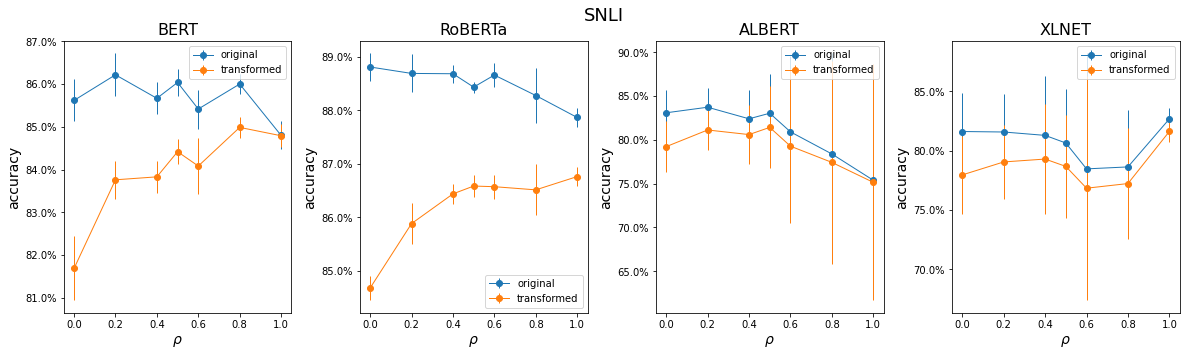

In [8]:
# SNLI

model = "xgb"
folder = "snli"
acc_snli_baseline = []
acc_t_snli_baseline = []
diff_snli_baseline = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_baseline.append(acc)
    acc_t_snli_baseline.append(acc_t)
    diff_snli_baseline.append(diff)
    
acc_snli_baseline = pd.concat(acc_snli_baseline, 1)
acc_snli_baseline.columns = batchs
acc_snli_baseline = acc_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

acc_t_snli_baseline = pd.concat(acc_t_snli_baseline, 1)
acc_t_snli_baseline.columns = batchs
acc_t_snli_baseline = acc_t_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

diff_snli_baseline = pd.concat(diff_snli_baseline, 1)
diff_snli_baseline.columns = batchs
diff_snli_baseline = diff_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

model = "bert_base"
folder = "snli"
acc_snli_bert = []
acc_t_snli_bert = []
diff_snli_bert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_bert.append(acc)
    acc_t_snli_bert.append(acc_t)
    diff_snli_bert.append(diff)
    
    
acc_snli_bert = pd.concat(acc_snli_bert, 1)
acc_snli_bert.columns = batchs

acc_t_snli_bert = pd.concat(acc_t_snli_bert, 1)
acc_t_snli_bert.columns = batchs

diff_snli_bert = pd.concat(diff_snli_bert, 1)
diff_snli_bert.columns = batchs



model = "roberta_base"
folder = "snli"
acc_snli_roberta = []
acc_t_snli_roberta = []
diff_snli_roberta = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_roberta.append(acc)
    acc_t_snli_roberta.append(acc_t)
    diff_snli_roberta.append(diff)
    
    
acc_snli_roberta = pd.concat(acc_snli_roberta, 1)
acc_snli_roberta.columns = batchs

acc_t_snli_roberta = pd.concat(acc_t_snli_roberta, 1)
acc_t_snli_roberta.columns = batchs

diff_snli_roberta = pd.concat(diff_snli_roberta, 1)
diff_snli_roberta.columns = batchs


model = "albert_base"
folder = "snli"
acc_snli_albert = []
acc_t_snli_albert = []
diff_snli_albert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_albert.append(acc)
    acc_t_snli_albert.append(acc_t)
    diff_snli_albert.append(diff)
    
acc_snli_albert = pd.concat(acc_snli_albert, 1)
acc_snli_albert.columns = batchs

acc_t_snli_albert = pd.concat(acc_t_snli_albert, 1)
acc_t_snli_albert.columns = batchs

diff_snli_albert = pd.concat(diff_snli_albert, 1)
diff_snli_albert.columns = batchs


model = "xlnet_base"
folder = "snli"
acc_snli_xlnet = []
acc_t_snli_xlnet = []
diff_snli_xlnet = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_xlnet.append(acc)
    acc_t_snli_xlnet.append(acc_t)
    diff_snli_xlnet.append(diff)
    
    
acc_snli_xlnet = pd.concat(acc_snli_xlnet, 1)
acc_snli_xlnet.columns = batchs

acc_t_snli_xlnet = pd.concat(acc_t_snli_xlnet, 1)
acc_t_snli_xlnet.columns = batchs


diff_snli_xlnet = pd.concat(diff_snli_xlnet, 1)
diff_snli_xlnet.columns = batchs

# PLOT

fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].errorbar(acc_snli_bert.index, acc_snli_bert.mean(1), yerr=acc_snli_bert.std(1), fmt='-o', linewidth=1.00, label="original");
ax[0].errorbar(acc_t_snli_bert.index, acc_t_snli_bert.mean(1), yerr=acc_t_snli_bert.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[0].set_xlabel(r"$\rho$", fontsize=14);
ax[0].set_ylabel("accuracy", fontsize=14);
ax[0].legend(loc="best");
ax[0].set_title("BERT", fontsize=16);
ax[0].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))


ax[1].errorbar(acc_snli_roberta.index, acc_snli_roberta.mean(1), yerr=acc_snli_roberta.std(1), fmt='-o', linewidth=1.00, label="original");
ax[1].errorbar(acc_t_snli_roberta.index, acc_t_snli_roberta.mean(1), yerr=acc_t_snli_roberta.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("accuracy", fontsize=14);
ax[1].legend(loc="best");
ax[1].set_title("RoBERTa", fontsize=16);
ax[1].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))


ax[2].errorbar(acc_snli_albert.index, acc_snli_albert.mean(1), yerr=acc_snli_albert.std(1), fmt='-o', linewidth=1.00, label="original");
ax[2].errorbar(acc_t_snli_albert.index, acc_t_snli_albert.mean(1), yerr=acc_t_snli_albert.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[2].set_xlabel(r"$\rho$", fontsize=14);
ax[2].set_ylabel("accuracy", fontsize=14);
ax[2].legend(loc="best");
ax[2].set_title("ALBERT", fontsize=16);
ax[2].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

ax[3].errorbar(acc_snli_xlnet.index, acc_snli_xlnet.mean(1), yerr=acc_snli_xlnet.std(1), fmt='-o', linewidth=1.00, label="original");
ax[3].errorbar(acc_t_snli_xlnet.index, acc_t_snli_xlnet.mean(1), yerr=acc_t_snli_xlnet.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[3].set_xlabel(r"$\rho$", fontsize=14);
ax[3].set_ylabel("accuracy", fontsize=14);
ax[3].legend(loc="best");
ax[3].set_title("XLNET", fontsize=16);
ax[3].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
plt.subplots_adjust(hspace=0.2, wspace=0.3);

plt.figtext(0.5, 0.95, 'SNLI', ha='center', va='center',fontsize=18);
fig.savefig('figs/paper/snli_acc.png', bbox_inches=None, pad_inches=0.5)
display(Markdown("# Accuracy-Deep-Models-SNLI"))



100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


# Accuracy-Deep-Models-MNLI

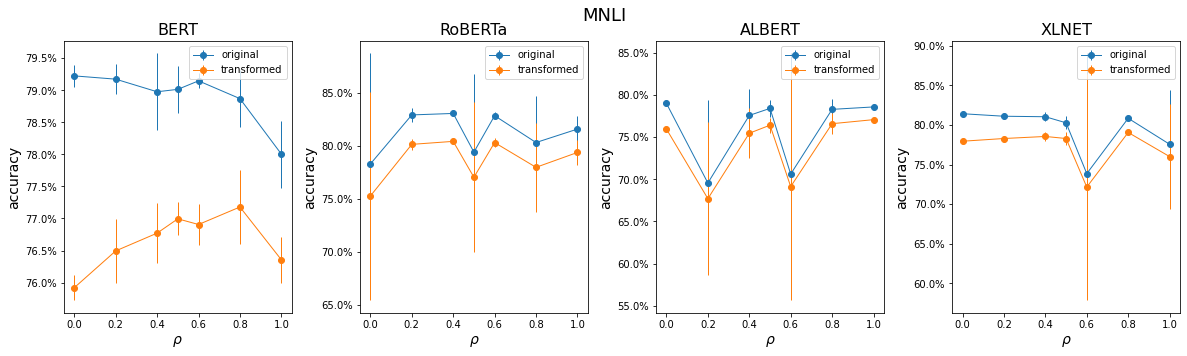

In [9]:
# MNLI


model = "xgb"
folder = "mnli"
acc_mnli_baseline = []
acc_t_mnli_baseline = []
diff_mnli_baseline = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_baseline.append(acc)
    acc_t_mnli_baseline.append(acc_t)
    diff_mnli_baseline.append(diff)
    
acc_mnli_baseline = pd.concat(acc_mnli_baseline, 1)
acc_mnli_baseline.columns = batchs
acc_mnli_baseline = acc_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

acc_t_mnli_baseline = pd.concat(acc_t_mnli_baseline, 1)
acc_t_mnli_baseline.columns = batchs
acc_t_mnli_baseline = acc_t_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

diff_mnli_baseline = pd.concat(diff_mnli_baseline, 1)
diff_mnli_baseline.columns = batchs
diff_mnli_baseline = diff_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

model = "bert_base"
folder = "mnli"
acc_mnli_bert = []
acc_t_mnli_bert = []
diff_mnli_bert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_bert.append(acc)
    acc_t_mnli_bert.append(acc_t)
    diff_mnli_bert.append(diff)
    
    
acc_mnli_bert = pd.concat(acc_mnli_bert, 1)
acc_mnli_bert.columns = batchs

acc_t_mnli_bert = pd.concat(acc_t_mnli_bert, 1)
acc_t_mnli_bert.columns = batchs

diff_mnli_bert = pd.concat(diff_mnli_bert, 1)
diff_mnli_bert.columns = batchs



model = "roberta_base"
folder = "mnli"
acc_mnli_roberta = []
acc_t_mnli_roberta = []
diff_mnli_roberta = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_roberta.append(acc)
    acc_t_mnli_roberta.append(acc_t)
    diff_mnli_roberta.append(diff)
    
    
acc_mnli_roberta = pd.concat(acc_mnli_roberta, 1)
acc_mnli_roberta.columns = batchs

acc_t_mnli_roberta = pd.concat(acc_t_mnli_roberta, 1)
acc_t_mnli_roberta.columns = batchs

diff_mnli_roberta = pd.concat(diff_mnli_roberta, 1)
diff_mnli_roberta.columns = batchs


model = "albert_base"
folder = "mnli"
acc_mnli_albert = []
acc_t_mnli_albert = []
diff_mnli_albert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_albert.append(acc)
    acc_t_mnli_albert.append(acc_t)
    diff_mnli_albert.append(diff)
    
acc_mnli_albert = pd.concat(acc_mnli_albert, 1)
acc_mnli_albert.columns = batchs

acc_t_mnli_albert = pd.concat(acc_t_mnli_albert, 1)
acc_t_mnli_albert.columns = batchs

diff_mnli_albert = pd.concat(diff_mnli_albert, 1)
diff_mnli_albert.columns = batchs


model = "xlnet_base"
folder = "mnli"
acc_mnli_xlnet = []
acc_t_mnli_xlnet = []
diff_mnli_xlnet = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_xlnet.append(acc)
    acc_t_mnli_xlnet.append(acc_t)
    diff_mnli_xlnet.append(diff)
    
    
acc_mnli_xlnet = pd.concat(acc_mnli_xlnet, 1)
acc_mnli_xlnet.columns = batchs

acc_t_mnli_xlnet = pd.concat(acc_t_mnli_xlnet, 1)
acc_t_mnli_xlnet.columns = batchs


diff_mnli_xlnet = pd.concat(diff_mnli_xlnet, 1)
diff_mnli_xlnet.columns = batchs

# PLOT

fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].errorbar(acc_mnli_bert.index, acc_mnli_bert.mean(1), yerr=acc_mnli_bert.std(1), fmt='-o', linewidth=1.00, label="original");
ax[0].errorbar(acc_t_mnli_bert.index, acc_t_mnli_bert.mean(1), yerr=acc_t_mnli_bert.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[0].set_xlabel(r"$\rho$", fontsize=14);
ax[0].set_ylabel("accuracy", fontsize=14);
ax[0].legend(loc="best");
ax[0].set_title("BERT", fontsize=16);
ax[0].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))


ax[1].errorbar(acc_mnli_roberta.index, acc_mnli_roberta.mean(1), yerr=acc_mnli_roberta.std(1), fmt='-o', linewidth=1.00, label="original");
ax[1].errorbar(acc_t_mnli_roberta.index, acc_t_mnli_roberta.mean(1), yerr=acc_t_mnli_roberta.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("accuracy", fontsize=14);
ax[1].legend(loc="best");
ax[1].set_title("RoBERTa", fontsize=16);
ax[1].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))


ax[2].errorbar(acc_mnli_albert.index, acc_mnli_albert.mean(1), yerr=acc_mnli_albert.std(1), fmt='-o', linewidth=1.00, label="original");
ax[2].errorbar(acc_t_mnli_albert.index, acc_t_mnli_albert.mean(1), yerr=acc_t_mnli_albert.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[2].set_xlabel(r"$\rho$", fontsize=14);
ax[2].set_ylabel("accuracy", fontsize=14);
ax[2].legend(loc="best");
ax[2].set_title("ALBERT", fontsize=16);
ax[2].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))


ax[3].errorbar(acc_mnli_xlnet.index, acc_mnli_xlnet.mean(1), yerr=acc_mnli_xlnet.std(1), fmt='-o', linewidth=1.00, label="original");
ax[3].errorbar(acc_t_mnli_xlnet.index, acc_t_mnli_xlnet.mean(1), yerr=acc_t_mnli_xlnet.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[3].set_xlabel(r"$\rho$", fontsize=14);
ax[3].set_ylabel("accuracy", fontsize=14);
ax[3].legend(loc="best");
ax[3].set_title("XLNET", fontsize=16);
ax[3].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

plt.figtext(0.5, 0.95, 'MNLI', ha='center', va='center',fontsize=18);
plt.subplots_adjust(hspace=0.2, wspace=0.3);

fig.savefig('figs/paper/mnli_acc.png', bbox_inches=None, pad_inches=0.5)
display(Markdown("# Accuracy-Deep-Models-MNLI"))

In [10]:
models = ["baseline", "BERT", "RoBERTa", "ALBERT", "XLNET"]
diffs = [diff_snli_baseline, diff_snli_bert,
         diff_snli_roberta, diff_snli_albert, 
         diff_snli_xlnet]

accs = [acc_snli_baseline, acc_snli_bert,
        acc_snli_roberta, acc_snli_albert, 
        acc_snli_xlnet]

accs_t = [acc_t_snli_baseline, acc_t_snli_bert,
          acc_t_snli_roberta, acc_t_snli_albert, 
          acc_t_snli_xlnet]

obs = []

for model,diff, acc, acc_t in zip(models, diffs, accs, accs_t):
    id_ = diff.mean(1).argmin()
    rho_star = diff.index[id_]
    obs.append((model, rho_star, acc.loc[0.0].mean(), acc.loc[rho_star].mean(), acc_t.loc[rho_star].mean()))

df = pd.DataFrame(obs, columns=["model", r"$\rho^*$","no noise test accuracy","test accuracy", "trasformed test accuracy"])
df[["no noise test accuracy","test accuracy", "trasformed test accuracy"]] = df[["no noise test accuracy","test accuracy", "trasformed test accuracy"]]
compare = df["no noise test accuracy"] - df["test accuracy"]
df.loc[:, "diff"] = compare*-1
df = df.drop("no noise test accuracy",1)
df[["test accuracy", "trasformed test accuracy", "diff"]] = df[["test accuracy", "trasformed test accuracy", "diff"]].apply(lambda row: row.map(lambda x: "{:.1%}".format(x)),1)
df_snli = df.copy()

models = ["baseline", "BERT", "RoBERTa", "ALBERT", "XLNET"]
diffs = [diff_mnli_baseline, diff_mnli_bert,
         diff_mnli_roberta, diff_mnli_albert, 
         diff_mnli_xlnet]

accs = [acc_mnli_baseline, acc_mnli_bert,
        acc_mnli_roberta, acc_mnli_albert, 
        acc_mnli_xlnet]

accs_t = [acc_t_mnli_baseline, acc_t_mnli_bert,
          acc_t_mnli_roberta, acc_t_mnli_albert, 
          acc_t_mnli_xlnet]

obs = []

for model,diff, acc, acc_t in zip(models, diffs, accs, accs_t):
    id_ = diff.mean(1).argmin()
    rho_star = diff.index[id_]
    obs.append((model, rho_star, acc.loc[0.0].mean(), acc.loc[rho_star].mean(), acc_t.loc[rho_star].mean()))

df = pd.DataFrame(obs, columns=["model", r"$\rho^*$","no noise test accuracy","test accuracy", "trasformed test accuracy"])
df[["no noise test accuracy","test accuracy", "trasformed test accuracy"]] = df[["no noise test accuracy","test accuracy", "trasformed test accuracy"]]
compare = df["no noise test accuracy"] - df["test accuracy"]
df.loc[:, "diff"] = compare*-1
df = df.drop("no noise test accuracy",1)
df[["test accuracy", "trasformed test accuracy", "diff"]] = df[["test accuracy", "trasformed test accuracy", "diff"]].apply(lambda row: row.map(lambda x: "{:.1%}".format(x)),1)
df_mnli = df.copy()

df_mnli.loc[:, "data"] = ["mnli"] * df_mnli.shape[0]
df_snli.loc[:, "data"] = ["snli"] * df_snli.shape[0]
df = pd.concat([df_snli, df_mnli])

columns = pd.MultiIndex.from_product([['SNLI', 'MNLI'], [r"$\rho^*$","test accuracy", "trasformed test accuracy", "diff"]],
                                     names=['', ' '])
new_obs = []

for model in models:
    obs = df.set_index(["model"]).xs(model).drop("data",1).values.flatten()
    new_obs.append(obs)
final_table = pd.DataFrame(new_obs,columns=columns, index=models)

display(Markdown("# Best-Rho-Table"))
display(HTML(final_table.to_html()))

# Best-Rho-Table

In [11]:
obs = []

models = ["BERT", "RoBERTa", "ALBERT", "XLNET"]

accs_snli = [acc_snli_bert,
             acc_snli_roberta,
             acc_snli_albert, 
             acc_snli_xlnet]

accs_t_snli = [acc_t_snli_bert,
               acc_t_snli_roberta,
               acc_t_snli_albert, 
               acc_t_snli_xlnet]

accs_mnli = [acc_mnli_bert,
             acc_mnli_roberta,
             acc_mnli_albert, 
             acc_mnli_xlnet]


accs_t_mnli = [acc_t_mnli_bert,
               acc_t_mnli_roberta,
               acc_t_mnli_albert, 
               acc_t_mnli_xlnet]

base = np.mean(acc_snli_baseline.values.flatten())
base_t = np.mean(acc_t_snli_baseline.values.flatten())

for model, acc, acc_t in zip(models, accs_snli, accs_t_snli):

    s = np.std(acc.values.flatten())
    m = np.mean(acc.values.flatten())
    sr =  (m - base)/s
    
    s_t = np.std(acc_t.values.flatten())
    m_t = np.mean(acc_t.values.flatten())
    sr_t = (m_t - base_t)/s_t
    obs.append((model,"snli",sr,sr_t))
    

base = np.mean(acc_mnli_baseline.values.flatten())
base_t = np.mean(acc_t_mnli_baseline.values.flatten())

for model, acc, acc_t in zip(models, accs_mnli, accs_t_mnli):

    s = np.std(acc.values.flatten())
    m = np.mean(acc.values.flatten())
    sr =  (m - base)/s
    
    s_t = np.std(acc_t.values.flatten())
    m_t = np.mean(acc_t.values.flatten())
    sr_t = (m_t - base_t)/s_t
    obs.append((model,"mnli",sr,sr_t))
    
    

df = pd.DataFrame(obs, columns=["model", "data", "original SR", "transformed SR"])
av = df.groupby("model").mean().mean(1)
av = [av[model] for model in models]


columns = pd.MultiIndex.from_product([['SNLI', 'MNLI'], ["original SR", "transformed SR"]],
                                     names=['', ' '])
new_obs = []

for model in models:
    obs = df.set_index(["model"]).xs(model).drop(columns=['data']).values.flatten()
    new_obs.append(obs)
final_table = pd.DataFrame(new_obs,columns=columns, index=models)
final_table.loc[:, "average "] = av

display(Markdown("# Model-Sharpe-Ratio"))
display(HTML(final_table.to_html()))

# Model-Sharpe-Ratio

## Acuraccy per category

## SNLI

100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


# T-Statistic-For-Each-Category-Deep-Model-SNLI

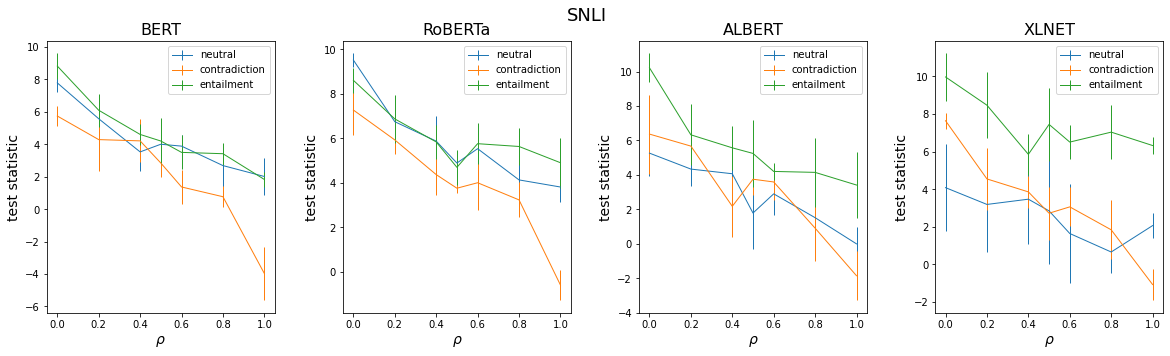

In [12]:
nli2ternary = {1:"entailment",
               0:"contradiction",
               2:"neutral"}
folder = "snli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)

model = "bert_base"
all_n_snli_bert = []
all_c_snli_bert = []
all_e_snli_bert = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_snli_bert.append(neutral_t)
    all_c_snli_bert.append(contradiction_t)
    all_e_snli_bert.append(entailment_t)
    
all_n_snli_bert = pd.concat(all_n_snli_bert, 1)
all_c_snli_bert = pd.concat(all_c_snli_bert, 1)
all_e_snli_bert = pd.concat(all_e_snli_bert, 1)

model = "roberta_base"
all_n_snli_roberta = []
all_c_snli_roberta = []
all_e_snli_roberta = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_snli_roberta.append(neutral_t)
    all_c_snli_roberta.append(contradiction_t)
    all_e_snli_roberta.append(entailment_t)
    
all_n_snli_roberta = pd.concat(all_n_snli_roberta, 1)
all_c_snli_roberta = pd.concat(all_c_snli_roberta, 1)
all_e_snli_roberta = pd.concat(all_e_snli_roberta, 1)

model = "albert_base"
all_n_snli_albert = []
all_c_snli_albert = []
all_e_snli_albert = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_snli_albert.append(neutral_t)
    all_c_snli_albert.append(contradiction_t)
    all_e_snli_albert.append(entailment_t)
    
all_n_snli_albert = pd.concat(all_n_snli_albert, 1)
all_c_snli_albert = pd.concat(all_c_snli_albert, 1)
all_e_snli_albert = pd.concat(all_e_snli_albert, 1)


model = "xlnet_base"
all_n_snli_xlnet = []
all_c_snli_xlnet = []
all_e_snli_xlnet = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_snli_xlnet.append(neutral_t)
    all_c_snli_xlnet.append(contradiction_t)
    all_e_snli_xlnet.append(entailment_t)
    
all_n_snli_xlnet = pd.concat(all_n_snli_xlnet, 1)
all_c_snli_xlnet = pd.concat(all_c_snli_xlnet, 1)
all_e_snli_xlnet = pd.concat(all_e_snli_xlnet, 1)

fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].errorbar(all_n_snli_bert.index, all_n_snli_bert.mean(1), yerr=all_n_snli_bert.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[0].errorbar(all_c_snli_bert.index, all_c_snli_bert.mean(1), yerr=all_c_snli_bert.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[0].errorbar(all_e_snli_bert.index, all_e_snli_bert.mean(1), yerr=all_e_snli_bert.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[0].set_xlabel(r"$\rho$", fontsize=14);
ax[0].set_ylabel("test statistic", fontsize=14);
ax[0].legend(loc="best");
ax[0].set_title("BERT", fontsize=16);

ax[1].errorbar(all_n_snli_roberta.index, all_n_snli_roberta.mean(1), yerr=all_n_snli_roberta.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[1].errorbar(all_c_snli_roberta.index, all_c_snli_roberta.mean(1), yerr=all_c_snli_roberta.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[1].errorbar(all_e_snli_roberta.index, all_e_snli_roberta.mean(1), yerr=all_e_snli_roberta.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("test statistic", fontsize=14);
ax[1].legend(loc="best");
ax[1].set_title("RoBERTa", fontsize=16);

ax[2].errorbar(all_n_snli_albert.index, all_n_snli_albert.mean(1), yerr=all_n_snli_albert.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[2].errorbar(all_c_snli_albert.index, all_c_snli_albert.mean(1), yerr=all_c_snli_albert.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[2].errorbar(all_e_snli_albert.index, all_e_snli_albert.mean(1), yerr=all_e_snli_albert.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[2].set_xlabel(r"$\rho$", fontsize=14);
ax[2].set_ylabel("test statistic", fontsize=14);
ax[2].legend(loc="best");
ax[2].set_title("ALBERT", fontsize=16);

ax[3].errorbar(all_n_snli_xlnet.index, all_n_snli_xlnet.mean(1), yerr=all_n_snli_xlnet.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[3].errorbar(all_c_snli_xlnet.index, all_c_snli_xlnet.mean(1), yerr=all_c_snli_xlnet.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[3].errorbar(all_e_snli_xlnet.index, all_e_snli_xlnet.mean(1), yerr=all_e_snli_xlnet.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[3].set_xlabel(r"$\rho$", fontsize=14);
ax[3].set_ylabel("test statistic", fontsize=14);
ax[3].legend(loc="best");
ax[3].set_title("XLNET", fontsize=16);

plt.subplots_adjust(hspace=0.2, wspace=0.3);

plt.figtext(0.5, 0.95, 'SNLI', ha='center', va='center',fontsize=18);
fig.savefig('figs/paper/snli_test_stat_per_cat.png', bbox_inches=None, pad_inches=0.5)

display(Markdown("# T-Statistic-For-Each-Category-Deep-Model-SNLI"))

## MNLI

 20%|██        | 1/5 [00:00<00:00,  8.42it/s]/home/felsal/Desktop/logical-robustness/src/lr/stats/h_testing.py:133: RuntimeWarning: invalid value encountered in double_scalars
  t = (diff.mean() * np.sqrt(n)) / S
100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


# T-Statistic-For-Each-Category-Deep-Model-MNLI

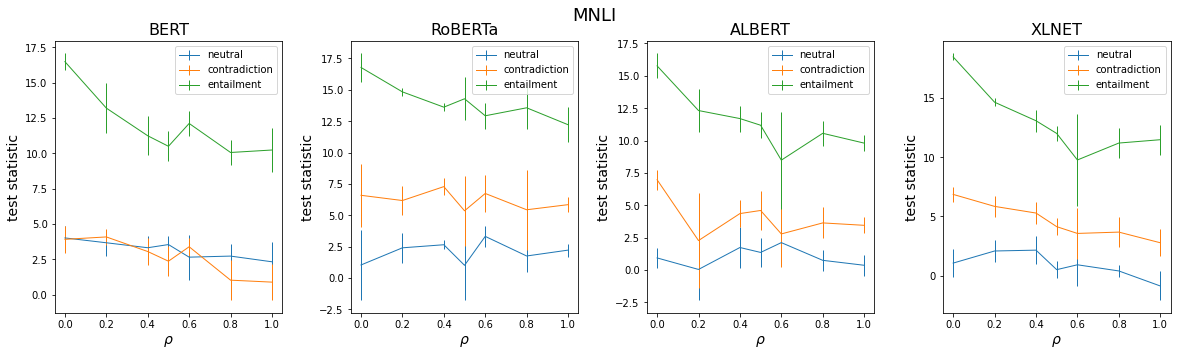

In [13]:
nli2ternary = {1:"entailment",
               0:"contradiction",
               2:"neutral"}
folder = "mnli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)

model = "bert_base"
all_n_mnli_bert = []
all_c_mnli_bert = []
all_e_mnli_bert = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_mnli_bert.append(neutral_t)
    all_c_mnli_bert.append(contradiction_t)
    all_e_mnli_bert.append(entailment_t)
    
all_n_mnli_bert = pd.concat(all_n_mnli_bert, 1)
all_c_mnli_bert = pd.concat(all_c_mnli_bert, 1)
all_e_mnli_bert = pd.concat(all_e_mnli_bert, 1)

model = "roberta_base"
all_n_mnli_roberta = []
all_c_mnli_roberta = []
all_e_mnli_roberta = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_mnli_roberta.append(neutral_t)
    all_c_mnli_roberta.append(contradiction_t)
    all_e_mnli_roberta.append(entailment_t)
    
all_n_mnli_roberta = pd.concat(all_n_mnli_roberta, 1)
all_c_mnli_roberta = pd.concat(all_c_mnli_roberta, 1)
all_e_mnli_roberta = pd.concat(all_e_mnli_roberta, 1)

model = "albert_base"
all_n_mnli_albert = []
all_c_mnli_albert = []
all_e_mnli_albert = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_mnli_albert.append(neutral_t)
    all_c_mnli_albert.append(contradiction_t)
    all_e_mnli_albert.append(entailment_t)
    
all_n_mnli_albert = pd.concat(all_n_mnli_albert, 1)
all_c_mnli_albert = pd.concat(all_c_mnli_albert, 1)
all_e_mnli_albert = pd.concat(all_e_mnli_albert, 1)


model = "xlnet_base"
all_n_mnli_xlnet = []
all_c_mnli_xlnet = []
all_e_mnli_xlnet = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_mnli_xlnet.append(neutral_t)
    all_c_mnli_xlnet.append(contradiction_t)
    all_e_mnli_xlnet.append(entailment_t)
    
all_n_mnli_xlnet = pd.concat(all_n_mnli_xlnet, 1)
all_c_mnli_xlnet = pd.concat(all_c_mnli_xlnet, 1)
all_e_mnli_xlnet = pd.concat(all_e_mnli_xlnet, 1)

fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].errorbar(all_n_mnli_bert.index, all_n_mnli_bert.mean(1), yerr=all_n_mnli_bert.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[0].errorbar(all_c_mnli_bert.index, all_c_mnli_bert.mean(1), yerr=all_c_mnli_bert.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[0].errorbar(all_e_mnli_bert.index, all_e_mnli_bert.mean(1), yerr=all_e_mnli_bert.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[0].set_xlabel(r"$\rho$", fontsize=14);
ax[0].set_ylabel("test statistic", fontsize=14);
ax[0].legend(loc="best");
ax[0].set_title("BERT", fontsize=16);

ax[1].errorbar(all_n_mnli_roberta.index, all_n_mnli_roberta.mean(1), yerr=all_n_mnli_roberta.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[1].errorbar(all_c_mnli_roberta.index, all_c_mnli_roberta.mean(1), yerr=all_c_mnli_roberta.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[1].errorbar(all_e_mnli_roberta.index, all_e_mnli_roberta.mean(1), yerr=all_e_mnli_roberta.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("test statistic", fontsize=14);
ax[1].legend(loc="best");
ax[1].set_title("RoBERTa", fontsize=16);

ax[2].errorbar(all_n_mnli_albert.index, all_n_mnli_albert.mean(1), yerr=all_n_mnli_albert.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[2].errorbar(all_c_mnli_albert.index, all_c_mnli_albert.mean(1), yerr=all_c_mnli_albert.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[2].errorbar(all_e_mnli_albert.index, all_e_mnli_albert.mean(1), yerr=all_e_mnli_albert.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[2].set_xlabel(r"$\rho$", fontsize=14);
ax[2].set_ylabel("test statistic", fontsize=14);
ax[2].legend(loc="best");
ax[2].set_title("ALBERT", fontsize=16);

ax[3].errorbar(all_n_mnli_xlnet.index, all_n_mnli_xlnet.mean(1), yerr=all_n_mnli_xlnet.std(1), fmt='-', linewidth=1.00, label="neutral");
ax[3].errorbar(all_c_mnli_xlnet.index, all_c_mnli_xlnet.mean(1), yerr=all_c_mnli_xlnet.std(1), fmt='-', linewidth=1.00, label="contradiction");
ax[3].errorbar(all_e_mnli_xlnet.index, all_e_mnli_xlnet.mean(1), yerr=all_e_mnli_xlnet.std(1), fmt='-', linewidth=1.00, label="entailment");
ax[3].set_xlabel(r"$\rho$", fontsize=14);
ax[3].set_ylabel("test statistic", fontsize=14);
ax[3].legend(loc="best");
ax[3].set_title("XLNET", fontsize=16);
plt.subplots_adjust(hspace=0.2, wspace=0.3);

plt.figtext(0.5, 0.95, 'MNLI', ha='center', va='center',fontsize=18);
fig.savefig('figs/paper/mnli_test_stat_per_cat.png', bbox_inches=None, pad_inches=0.5)

display(Markdown("# T-Statistic-For-Each-Category-Deep-Model-MNLI"))

## Accuracy for the entailment part of the data
### SNLI

100%|██████████| 5/5 [00:00<00:00, 18.37it/s]


# Accuracy-For-The-Entailment-Category-Deep-Model-SNLI

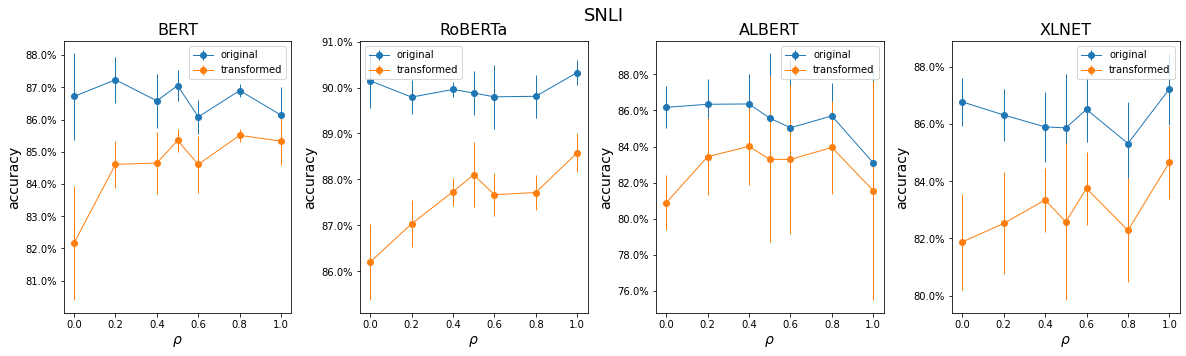

In [14]:
nli2ternary = {1:"entailment",
               0:"contradiction",
               2:"neutral"}
folder = "snli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)

model = "bert_base"
acc_snli_bert = []
acc_t_snli_bert = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    acc, acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    acc_snli_bert.append(acc)
    acc_t_snli_bert.append(acc_t)
    
acc_snli_bert = pd.concat(acc_snli_bert, 1)
acc_t_snli_bert = pd.concat(acc_t_snli_bert, 1)

model = "roberta_base"
acc_snli_roberta = []
acc_t_snli_roberta = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    acc, acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    acc_snli_roberta.append(acc)
    acc_t_snli_roberta.append(acc_t)
    
acc_snli_roberta = pd.concat(acc_snli_roberta, 1)
acc_t_snli_roberta = pd.concat(acc_t_snli_roberta, 1)

model = "albert_base"
acc_snli_albert = []
acc_t_snli_albert = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    acc, acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    acc_snli_albert.append(acc)
    acc_t_snli_albert.append(acc_t)
    
acc_snli_albert = pd.concat(acc_snli_albert, 1)
acc_t_snli_albert = pd.concat(acc_t_snli_albert, 1)

model = "xlnet_base"
acc_snli_xlnet = []
acc_t_snli_xlnet = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    acc, acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    acc_snli_xlnet.append(acc)
    acc_t_snli_xlnet.append(acc_t)
    
acc_snli_xlnet = pd.concat(acc_snli_xlnet, 1)
acc_t_snli_xlnet = pd.concat(acc_t_snli_xlnet, 1)



fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].errorbar(acc_snli_bert.index, acc_snli_bert.mean(1), yerr=acc_snli_bert.std(1), fmt='-o', linewidth=1.00, label="original");
ax[0].errorbar(acc_t_snli_bert.index, acc_t_snli_bert.mean(1), yerr=acc_t_snli_bert.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[0].set_xlabel(r"$\rho$", fontsize=14);
ax[0].set_ylabel("accuracy", fontsize=14);
ax[0].legend(loc="best");
ax[0].set_title("BERT", fontsize=16);
ax[0].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

ax[1].errorbar(acc_snli_roberta.index, acc_snli_roberta.mean(1), yerr=acc_snli_roberta.std(1),fmt='-o', linewidth=1.00, label="original");
ax[1].errorbar(acc_t_snli_roberta.index, acc_t_snli_roberta.mean(1), yerr=acc_t_snli_roberta.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("accuracy", fontsize=14);
ax[1].legend(loc="best");
ax[1].set_title("RoBERTa", fontsize=16);
ax[1].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

ax[2].errorbar(acc_snli_albert.index, acc_snli_albert.mean(1), yerr=acc_snli_albert.std(1), fmt='-o', linewidth=1.00, label="original");
ax[2].errorbar(acc_t_snli_albert.index, acc_t_snli_albert.mean(1), yerr=acc_t_snli_albert.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[2].set_xlabel(r"$\rho$", fontsize=14);
ax[2].set_ylabel("accuracy", fontsize=14);
ax[2].legend(loc="best");
ax[2].set_title("ALBERT", fontsize=16);
ax[2].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

ax[3].errorbar(acc_snli_xlnet.index, acc_snli_xlnet.mean(1), yerr=acc_snli_xlnet.std(1), fmt='-o', linewidth=1.00, label="original");
ax[3].errorbar(acc_t_snli_xlnet.index, acc_t_snli_xlnet.mean(1), yerr=acc_t_snli_xlnet.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[3].set_xlabel(r"$\rho$", fontsize=14);
ax[3].set_ylabel("accuracy", fontsize=14);
ax[3].legend(loc="best");
ax[3].set_title("XLNET", fontsize=16);
ax[3].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

plt.subplots_adjust(hspace=0.2, wspace=0.3);

plt.figtext(0.5, 0.95, 'SNLI', ha='center', va='center',fontsize=18);
fig.savefig('figs/paper/snli_acc_entailment.png', bbox_inches=None, pad_inches=0.5)
display(Markdown("# Accuracy-For-The-Entailment-Category-Deep-Model-SNLI"))

### MNLI

100%|██████████| 5/5 [00:00<00:00, 14.42it/s]


# Accuracy-For-The-Entailment-Category-Deep-Model-MNLI

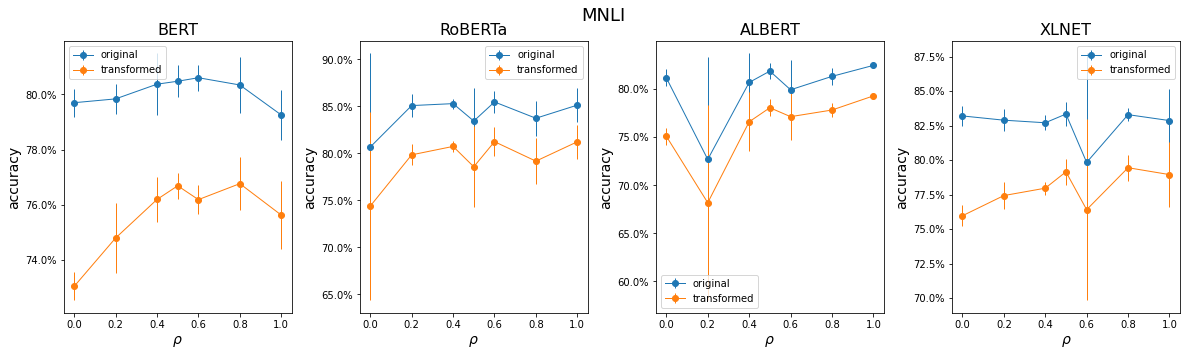

In [15]:
nli2ternary = {1:"entailment",
               0:"contradiction",
               2:"neutral"}
folder = "mnli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)

model = "bert_base"
acc_mnli_bert = []
acc_t_mnli_bert = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    acc, acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    acc_mnli_bert.append(acc)
    acc_t_mnli_bert.append(acc_t)
    
acc_mnli_bert = pd.concat(acc_mnli_bert, 1)
acc_t_mnli_bert = pd.concat(acc_t_mnli_bert, 1)

model = "roberta_base"
acc_mnli_roberta = []
acc_t_mnli_roberta = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    acc, acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    acc_mnli_roberta.append(acc)
    acc_t_mnli_roberta.append(acc_t)
    
acc_mnli_roberta = pd.concat(acc_mnli_roberta, 1)
acc_t_mnli_roberta = pd.concat(acc_t_mnli_roberta, 1)

model = "albert_base"
acc_mnli_albert = []
acc_t_mnli_albert = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    acc, acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    acc_mnli_albert.append(acc)
    acc_t_mnli_albert.append(acc_t)
    
acc_mnli_albert = pd.concat(acc_mnli_albert, 1)
acc_t_mnli_albert = pd.concat(acc_t_mnli_albert, 1)

model = "xlnet_base"
acc_mnli_xlnet = []
acc_t_mnli_xlnet = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    base_path = "raw_results/{}/{}/syn_p_h/batch{}/*.csv".format(folder,model, i)
    acc, acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    acc_mnli_xlnet.append(acc)
    acc_t_mnli_xlnet.append(acc_t)
    
acc_mnli_xlnet = pd.concat(acc_mnli_xlnet, 1)
acc_t_mnli_xlnet = pd.concat(acc_t_mnli_xlnet, 1)

fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].errorbar(acc_mnli_bert.index, acc_mnli_bert.mean(1), yerr=acc_mnli_bert.std(1), fmt='-o', linewidth=1.00, label="original");
ax[0].errorbar(acc_t_mnli_bert.index, acc_t_mnli_bert.mean(1), yerr=acc_t_mnli_bert.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[0].set_xlabel(r"$\rho$", fontsize=14);
ax[0].set_ylabel("accuracy", fontsize=14);
ax[0].legend(loc="best");
ax[0].set_title("BERT", fontsize=16);
ax[0].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

ax[1].errorbar(acc_mnli_roberta.index, acc_mnli_roberta.mean(1), yerr=acc_mnli_roberta.std(1), fmt='-o', linewidth=1.00, label="original");
ax[1].errorbar(acc_t_mnli_roberta.index, acc_t_mnli_roberta.mean(1), yerr=acc_t_mnli_roberta.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("accuracy", fontsize=14);
ax[1].legend(loc="best");
ax[1].set_title("RoBERTa", fontsize=16);
ax[1].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

ax[2].errorbar(acc_mnli_albert.index, acc_mnli_albert.mean(1), yerr=acc_mnli_albert.std(1),fmt='-o', linewidth=1.00, label="original");
ax[2].errorbar(acc_t_mnli_albert.index, acc_t_mnli_albert.mean(1), yerr=acc_t_mnli_albert.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[2].set_xlabel(r"$\rho$", fontsize=14);
ax[2].set_ylabel("accuracy", fontsize=14);
ax[2].legend(loc="best");
ax[2].set_title("ALBERT", fontsize=16);
ax[2].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

ax[3].errorbar(acc_mnli_xlnet.index, acc_mnli_xlnet.mean(1), yerr=acc_mnli_xlnet.std(1), fmt='-o', linewidth=1.00, label="original");
ax[3].errorbar(acc_t_mnli_xlnet.index, acc_t_mnli_xlnet.mean(1), yerr=acc_t_mnli_xlnet.std(1), fmt='-o', linewidth=1.00, label="transformed");
ax[3].set_xlabel(r"$\rho$", fontsize=14);
ax[3].set_ylabel("accuracy", fontsize=14);
ax[3].legend(loc="best");
ax[3].set_title("XLNET", fontsize=16);
ax[3].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

plt.subplots_adjust(hspace=0.2, wspace=0.3);

plt.figtext(0.5, 0.95, 'MNLI', ha='center', va='center',fontsize=18);
fig.savefig('figs/paper/mnli_acc_entailment.png', bbox_inches=None, pad_inches=0.5)
display(Markdown("# Accuracy-For-The-Entailment-Category-Deep-Model-MNLI"))